# Import the libraries

In [1]:
from preprocessing_CNN import Train_Validation_Test_Split

import numpy as np
import pandas as pd

import os
import shutil

import pickle as pk

import cv2 
import matplotlib.pyplot as plt
%matplotlib inline 

from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.applications import VGG19

# Data pre-processing

## Train-Validation-Test Split

In [2]:
c_train, d_train, c_val, d_val, c_test, d_test = Train_Validation_Test_Split('cats', 'dogs')

Final number of cat pictures: 12500
Final number of dog pictures: 12500

-----------------------------------------------------------------

Start to determine test, validation and train part
Stop to determine test, validation and train part

Start to set folder structure
Stop to set folder structure

Start copying the determined images to the appropriate folders
Stop copying the determined images to the appropriate folders

-----------------------------------------------------------------

          The final data breakdown is as follows:

Total training cat images: 7500
Total training dog images: 7500

Total validation cat images: 2500
Total validation dog images: 2500

Total test cat images: 2500
Total test dog images: 2500


## Obtaining the lists of randomly selected images

In [3]:
list_cats_training = c_train
list_dogs_training = d_train

list_cats_validation = c_val
list_dogs_validation = d_val

list_cats_test = c_test
list_dogs_test = d_test

## Determination of the directories

In [4]:
root_directory = os.getcwd()

train_dir = os.path.join(root_directory, 'cats_and_dogs\\train')
validation_dir = os.path.join(root_directory, 'cats_and_dogs\\validation')
test_dir = os.path.join(root_directory, 'cats_and_dogs\\test')

## Obtain the total number of training, validation and test images

In [5]:
num_cats_img_train = len(list_cats_training)
num_dogs_img_train = len(list_dogs_training)

num_train_images_total = num_cats_img_train + num_dogs_img_train

print('Total training cat images: ' + str(num_cats_img_train))
print('Total training dog images: ' + str(num_dogs_img_train))
print()
print('Total training images: ' + str(num_train_images_total))

Total training cat images: 7500
Total training dog images: 7500

Total training images: 15000


In [6]:
num_cats_img_validation = len(list_cats_validation)
num_dogs_img_validation = len(list_dogs_validation)

num_validation_images_total = num_cats_img_validation + num_dogs_img_validation

print('Total validation cat images: ' + str(num_cats_img_validation))
print('Total validation dog images: ' + str(num_dogs_img_validation))
print()
print('Total validation images: ' + str(num_validation_images_total))

Total validation cat images: 2500
Total validation dog images: 2500

Total validation images: 5000


In [7]:
num_cats_img_test = len(list_cats_test)
num_dogs_img_test = len(list_dogs_test)

num_test_images_total = num_cats_img_test + num_dogs_img_test

print('Total test cat images: ' + str(num_cats_img_test))
print('Total test dog images: ' + str(num_dogs_img_test))
print()
print('Total test images: ' + str(num_test_images_total))

Total test cat images: 2500
Total test dog images: 2500

Total test images: 5000


# Feature Extraction without Data Augmentation

## Name Definitions

In [8]:
checkpoint_no = 'ckpt_1_CNN_with_TF_VGG19'
model_name = 'Cats_Dogs_CNN_TF_VGG19_epoch_30'

## Parameter Settings

In [9]:
img_height = 150
img_width = 150
input_shape = (img_height, img_width, 3)

n_batch_size = 32

n_epochs = 30

print('Input Shape: '+'('+str(img_height)+', '+str(img_width)+', ' + str(3)+')')
print('Batch Size: ' + str(n_batch_size))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: (150, 150, 3)
Batch Size: 32

Number of Epochs: 30


## Instantiating the VGG19 convolutional base

In [10]:
VGG19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base = VGG19_base

In [11]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature Extraction

### Get Output Shape of last Layer

In [12]:
df_temp = pd.DataFrame()

for layer in conv_base.layers:
    layer_output_shape = layer.output_shape

    df1 = {'Output_Shape': layer_output_shape}
    df_temp = df_temp.append(df1, ignore_index=True)

df_temp

,Output_Shape
0,"[(None, 150, 150, 3)]"
1,"(None, 150, 150, 64)"
2,"(None, 150, 150, 64)"
3,"(None, 75, 75, 64)"
4,"(None, 75, 75, 128)"
5,"(None, 75, 75, 128)"
6,"(None, 37, 37, 128)"
7,"(None, 37, 37, 256)"
8,"(None, 37, 37, 256)"
9,"(None, 37, 37, 256)"


In [13]:
df_temp = df_temp.loc[df_temp.index == df_temp.index.max()]
df_temp = df_temp['Output_Shape'].iloc[0]
df_temp

(None, 4, 4, 512)

In [14]:
df_temp2 = pd.DataFrame(df_temp).T
df_temp2.columns= ['batch_size', 'pooled_rows', 'pooled_cols', 'channels']
df_temp2['pooled_rows'] = df_temp2['pooled_rows'].astype('int64')
df_temp2['pooled_cols'] = df_temp2['pooled_cols'].astype('int64')
df_temp2['channels'] = df_temp2['channels'].astype('int64')
df_temp2

,batch_size,pooled_rows,pooled_cols,channels
0,NaN,4,4,512


In [15]:
n_pooled_rows = df_temp2['pooled_rows'].iloc[0]
n_pooled_cols = df_temp2['pooled_cols'].iloc[0]
n_channels = df_temp2['channels'].iloc[0]

print('Number of pooled rows: ' + str(n_pooled_rows))
print('Number of pooled cols: ' + str(n_pooled_cols))
print('Number of channels: ' + str(n_channels))

Number of pooled rows: 4
Number of pooled cols: 4
Number of channels: 512


### Extracting features using the pretrained convolutional base

In [16]:
datagen = ImageDataGenerator(rescale=1./255)


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, n_pooled_rows, n_pooled_cols, n_channels))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')
    
    class_assignments = generator.class_indices
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * n_batch_size : (i + 1) * n_batch_size] = features_batch
        labels[i * n_batch_size : (i + 1) * n_batch_size] = labels_batch
        i += 1
        if i * n_batch_size >= sample_count:
            break
    return features, labels, class_assignments

In [17]:
train_features, train_labels, train_class_assignments = extract_features(train_dir, num_train_images_total)
validation_features, validation_labels, validation_class_assignments = extract_features(validation_dir, num_validation_images_total)
test_features, test_labels, test_class_assignments = extract_features(test_dir, num_test_images_total)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Reshape train-, validation- and test features

The extracted features are currently of shape *(samples, 4, 4, 512)*. We are going to feed them to a densely connected classifier, so first we must flatten them to *(samples, 8192)*.

In [18]:
train_features = np.reshape(train_features, (num_train_images_total, 
                                             n_pooled_rows * n_pooled_cols * n_channels))

validation_features = np.reshape(validation_features, (num_validation_images_total, 
                                                       n_pooled_rows * n_pooled_cols * n_channels))

test_features = np.reshape(test_features, (num_test_images_total, 
                                           n_pooled_rows * n_pooled_cols * n_channels))

## Instantiating a densely connected classifier

### Layer Structure

In [19]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', 
                       input_dim= n_pooled_rows * n_pooled_cols * n_channels))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Configuring the model for training

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Callbacks

In [22]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [23]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

## Fitting the model

In [24]:
history = model.fit(
    train_features, train_labels,
    epochs = n_epochs,
    batch_size = n_batch_size,
    validation_data = (validation_features, validation_labels),
    callbacks=keras_callbacks)

Epoch 1/30
469/469 [==============================] - 9s 14ms/step - loss: 0.4625 - accuracy: 0.8043 - val_loss: 0.2947 - val_accuracy: 0.8750
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TF_VGG19\Cats_Dogs_CNN_TF_VGG19_epoch_30\assets
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2827 - accuracy: 0.8780 - val_loss: 0.2451 - val_accuracy: 0.9004
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TF_VGG19\Cats_Dogs_CNN_TF_VGG19_epoch_30\assets
Epoch 3/30
469/469 [==============================] - 7s 14ms/step - loss: 0.2607 - accuracy: 0.8890 - val_loss: 0.2382 - val_accuracy: 0.9020
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TF_VGG19\Cats_Dogs_CNN_TF_VGG19_epoch_30\assets
Epoch 4/30
469/469 [==============================] - 12s 25ms/step - loss: 0.2408 - accuracy: 0.8968 - val_loss: 0.2474 - val_accuracy: 0.8972
Epoch 5/30
469/469 [==============================] - 12s 25ms/step - loss: 0.2138 - accuracy: 0.9078 - val_loss: 0.2421 - val_accu

## Obtaining the best model values

In [25]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.371545,0.836133,0.294677,0.8750
1,2,0.284060,0.876933,0.245102,0.9004
2,3,0.257849,0.889933,0.238195,0.9020
3,4,0.236762,0.897467,0.247403,0.8972
4,5,0.218838,0.908000,0.242120,0.8976


In [26]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
5,6,0.212861,0.908533,0.229135,0.905


## Obtaining class assignments

In [27]:
class_assignment = train_class_assignments

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'cats': 0, 'dogs': 1}


## Validation

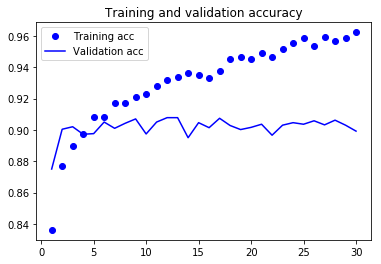

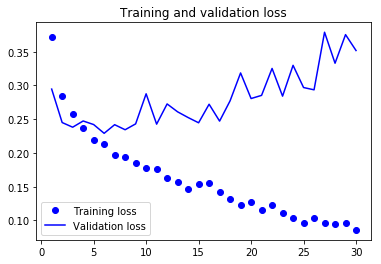

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load best model

In [29]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [30]:
best_model = load_model(model_name_temp)

## Model Testing

In [31]:
test_loss, test_acc = best_model.evaluate(test_features, test_labels, 
                                          batch_size = n_batch_size)
print()
print('Test Accuracy:', test_acc)

157/157 [==============================] - 2s 11ms/step - loss: 0.2346 - accuracy: 0.8962 0s - loss: 0.2355 - accuracy: 0.89

Test Accuracy: 0.8962000012397766


In [32]:
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))

pk.dump(n_pooled_rows, open(checkpoint_dir+ '\\' +'n_pooled_rows.pkl', 'wb'))
pk.dump(n_pooled_cols, open(checkpoint_dir+ '\\' +'n_pooled_cols.pkl', 'wb'))
pk.dump(n_channels, open(checkpoint_dir+ '\\' +'n_channels.pkl', 'wb'))

## Test Out of the Box Pictures

In [33]:
# Determine Checkpoint Dir
checkpoint_dir = 'ckpt_1_CNN_with_TF_VGG19'

# Load best model
best_model = load_model(checkpoint_dir + '/' + 'Cats_Dogs_CNN_TF_VGG19_epoch_30.h5')

# Load the categories
df = pd.read_csv(checkpoint_dir + '/' + 'class_assignment_df_Cats_Dogs_CNN_TF_VGG19_epoch_30.csv')
df = df.sort_values(by='Allocated Number', ascending=True)
CATEGORIES = df['Category'].to_list()


# Load the used image height and width
img_height_reload = pk.load(open(checkpoint_dir + '/' + 'img_height.pkl','rb'))
img_width_reload = pk.load(open(checkpoint_dir + '/' + 'img_width.pkl','rb'))


# Load the used n_pooled_rows, n_pooled_cols and n_channels
n_pooled_rows_reload = pk.load(open(checkpoint_dir + '/' + 'n_pooled_rows.pkl','rb'))
n_pooled_cols_reload = pk.load(open(checkpoint_dir + '/' + 'n_pooled_cols.pkl','rb'))
n_channels_reload = pk.load(open(checkpoint_dir + '/' + 'n_channels.pkl','rb'))

print('Model Summary :' + str(best_model.summary()))
print()
print()
print('CATEGORIES : ' + str(CATEGORIES))
print()
print('Used image height: ' + str(img_height_reload))
print('Used image width: ' + str(img_width_reload))
print()
print('Used n_pooled_rows: ' + str(n_pooled_rows))
print('Used n_pooled_cols: ' + str(n_pooled_cols))
print('Used n_channels: ' + str(n_channels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Model Summary :None


CATEGORIES : ['cats', 'dogs']

Used image height: 150
Used image width: 150

Used n_pooled_rows: 4
Used n_pooled_cols: 4
Used n_channels: 512


AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


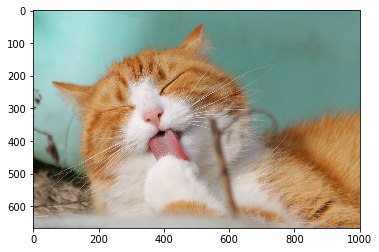

In [34]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = np.zeros(shape=(1, n_pooled_rows_reload, n_pooled_cols_reload, n_channels_reload))
img_pred = np.reshape(img_pred, (1, n_pooled_rows_reload * n_pooled_cols_reload * n_channels_reload))

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


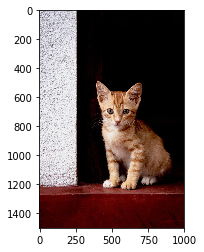

In [35]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = np.zeros(shape=(1, n_pooled_rows_reload, n_pooled_cols_reload, n_channels_reload))
img_pred = np.reshape(img_pred, (1, n_pooled_rows_reload * n_pooled_cols_reload * n_channels_reload))

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


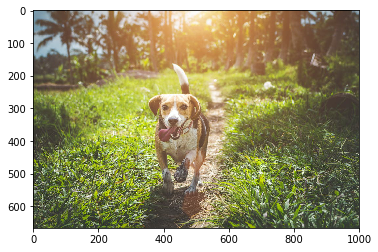

In [36]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = np.zeros(shape=(1, n_pooled_rows_reload, n_pooled_cols_reload, n_channels_reload))
img_pred = np.reshape(img_pred, (1, n_pooled_rows_reload * n_pooled_cols_reload * n_channels_reload))

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


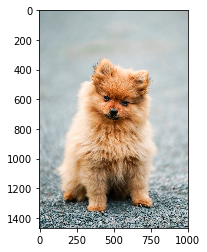

In [37]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = np.zeros(shape=(1, n_pooled_rows_reload, n_pooled_cols_reload, n_channels_reload))
img_pred = np.reshape(img_pred, (1, n_pooled_rows_reload * n_pooled_cols_reload * n_channels_reload))

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

# Feature Extraction with Data Augmentation

## Name Definitions

In [38]:
checkpoint_no = 'ckpt_2_CNN_with_TF_VGG19_with_DataAug'
model_name = 'Cats_Dogs_CNN_TF_VGG19_with_DataAug_epoch_30_ES'

## Parameter Settings

In [39]:
img_height = 150
img_width = 150
input_shape = (img_height, img_width, 3)

n_batch_size = 32

n_steps_per_epoch = int(num_train_images_total / n_batch_size)
n_validation_steps = int(num_validation_images_total / n_batch_size)
n_test_steps = int(num_test_images_total / n_batch_size)

n_epochs = 30

print('Input Shape: '+'('+str(img_height)+', '+str(img_width)+', ' + str(3)+')')
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: (150, 150, 3)
Batch Size: 32

Steps per Epoch: 468

Validation Steps: 156
Test Steps: 156

Number of Epochs: 30


## Instantiating the VGG19 convolutional base

In [40]:
VGG19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base = VGG19_base

## Instantiating a densely connected classifier

### Layer Structure

In [41]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [43]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 36


In [44]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [46]:
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights after freezing the conv base: 4


### Configuring the model for training

In [47]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Using ImageDataGenerator

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')



Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Callbacks

In [49]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [50]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir, 
                                   monitor='val_loss', save_best_only=True, mode='auto'),
                   EarlyStopping(monitor='val_loss', patience=5, mode='auto', 
                                 min_delta = 0, verbose=1)]

## Fitting the model

In [51]:
history = model.fit(
      train_generator,
      steps_per_epoch=n_steps_per_epoch,
      epochs=n_epochs,
      validation_data=validation_generator,
      validation_steps=n_validation_steps,
      callbacks=keras_callbacks)

Epoch 1/30
468/468 [==============================] - 1764s 4s/step - loss: 0.5564 - accuracy: 0.7508 - val_loss: 0.3081 - val_accuracy: 0.8616
INFO:tensorflow:Assets written to: ckpt_2_CNN_with_TF_VGG19_with_DataAug\assets
Epoch 2/30
468/468 [==============================] - 1675s 4s/step - loss: 0.3819 - accuracy: 0.8222 - val_loss: 0.2676 - val_accuracy: 0.8840
INFO:tensorflow:Assets written to: ckpt_2_CNN_with_TF_VGG19_with_DataAug\assets
Epoch 3/30
468/468 [==============================] - 1749s 4s/step - loss: 0.3494 - accuracy: 0.8416 - val_loss: 0.2571 - val_accuracy: 0.8880
INFO:tensorflow:Assets written to: ckpt_2_CNN_with_TF_VGG19_with_DataAug\assets
Epoch 4/30
468/468 [==============================] - 1810s 4s/step - loss: 0.3660 - accuracy: 0.8316 - val_loss: 0.2680 - val_accuracy: 0.8850
Epoch 5/30
468/468 [==============================] - 1753s 4s/step - loss: 0.3414 - accuracy: 0.8398 - val_loss: 0.3845 - val_accuracy: 0.8301
Epoch 6/30
468/468 [====================

## Obtaining the best model values

In [52]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.448582,0.792825,0.308119,0.861579
1,2,0.379657,0.823624,0.267640,0.884014
2,3,0.356681,0.835716,0.257100,0.888021
3,4,0.357554,0.835850,0.268008,0.885016
4,5,0.346314,0.839591,0.384496,0.830128


In [53]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
21,22,0.301604,0.86391,0.215273,0.907652


## Obtaining class assignments

In [54]:
class_assignment = train_generator.class_indices

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'cats': 0, 'dogs': 1}


## Validation

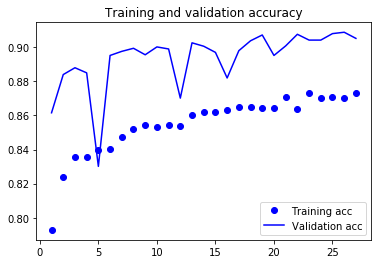

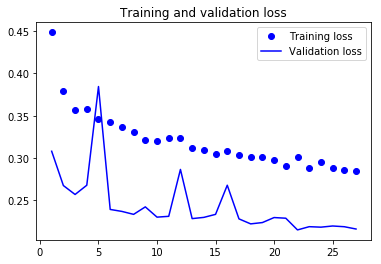

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load best model

In [56]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folders/.pb file under Model Checkpoint File.
folder_name_temp1 = os.path.join(checkpoint_dir, 'assets')
folder_name_temp2 = os.path.join(checkpoint_dir, 'variables')
file_name_temp = os.path.join(checkpoint_dir, 'saved_model.pb')

shutil.move(file_name_temp, folder_name_temp1)
shutil.rmtree(folder_name_temp1, ignore_errors=True)
shutil.rmtree(folder_name_temp2, ignore_errors=True)

In [57]:
best_model = load_model(model_name_temp)

## Model Testing

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')

test_loss, test_acc = best_model.evaluate(test_generator, steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

Found 5000 images belonging to 2 classes.
156/156 [==============================] - 329s 2s/step - loss: 0.2240 - accuracy: 0.9024

Test Accuracy: 0.9024438858032227


In [59]:
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))

## Test Out of the Box Pictures

In [60]:
# Determine Checkpoint Dir
checkpoint_dir = 'ckpt_2_CNN_with_TF_VGG19_with_DataAug'

# Load best model
best_model = load_model(checkpoint_dir + '/' + 'Cats_Dogs_CNN_TF_VGG19_with_DataAug_epoch_30_ES.h5')

# Load the categories
df = pd.read_csv(checkpoint_dir + '/' + 'class_assignment_df_Cats_Dogs_CNN_TF_VGG19_with_DataAug_epoch_30_ES.csv')
df = df.sort_values(by='Allocated Number', ascending=True)
CATEGORIES = df['Category'].to_list()


# Load the used image height and width
img_height_reload = pk.load(open(checkpoint_dir + '/' + 'img_height.pkl','rb'))
img_width_reload = pk.load(open(checkpoint_dir + '/' + 'img_width.pkl','rb'))


print('Model Summary :' + str(best_model.summary()))
print()
print()
print('CATEGORIES : ' + str(CATEGORIES))
print()
print('Used image height: ' + str(img_height_reload))
print('Used image width: ' + str(img_width_reload))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________
Model Summary :None


CATEGORIES : ['cats', 'dogs']

Used image height: 150
Used image width: 150


AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


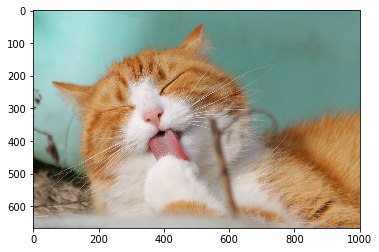

In [61]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


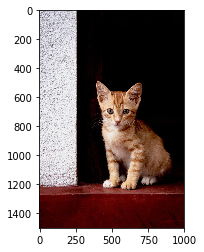

In [62]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: dogs
------------------------------------


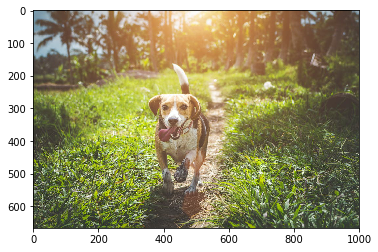

In [63]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: dogs
------------------------------------


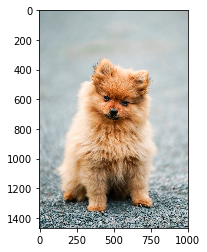

In [64]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')